In [103]:
import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi


# Load the environment variables
load_dotenv()

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_BASE_URL = os.getenv("ALPACA_BASE_URL")


api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, ALPACA_BASE_URL)


try:
    account = api.get_account()
    print(f"Account status: {account.status}")
    print(f"Equity: ${account.equity}")
    print(f"Buying Power: ${account.buying_power}")
except Exception as e:
    print(f"Error connecting to Alpaca: {e}")

Account status: ACTIVE
Equity: $99760.22
Buying Power: $189389.89


## Experiementing with S&P 500 Data

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [105]:
stock_data = pd.read_csv("all_stocks_5yr.csv")
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date', inplace=True)

stock_data.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


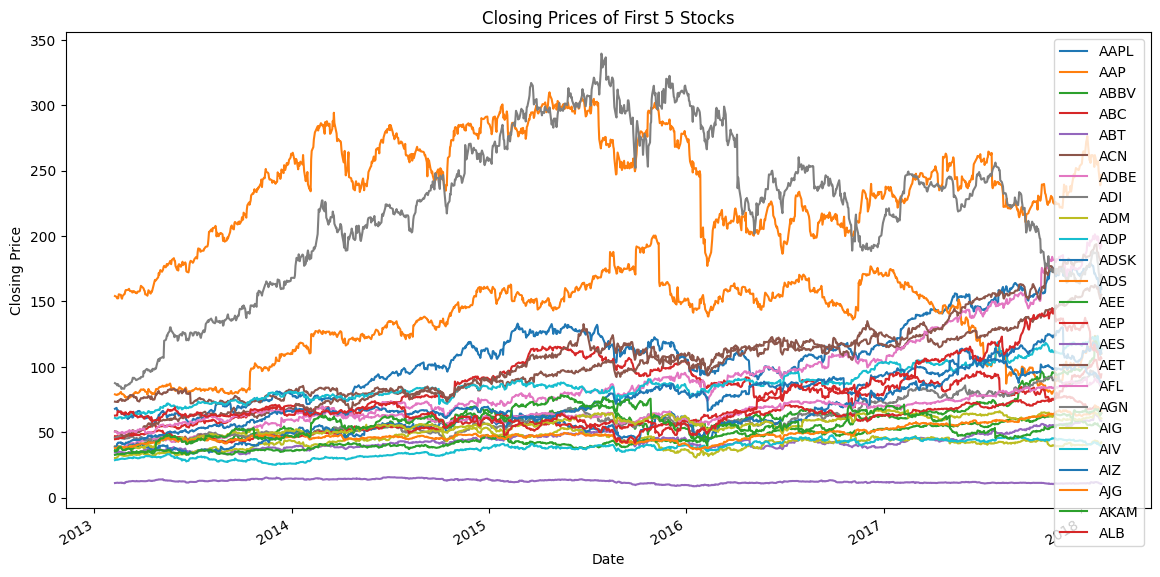

In [106]:



# Plotting the closing prices of the first 10 stocks
plt.figure(figsize=(14, 7))
for name in stock_data['Name'].unique()[1:25]:
    stock_data[stock_data['Name'] == name]['close'].plot(label=name)

plt.title('Closing Prices of First 5 Stocks')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Need to clean the data first

In [107]:
stock_data = stock_data.dropna()

## Splitting the data into a 20-80 test and train

In [108]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(stock_data, test_size=0.2, random_state=69)

In [109]:
from sklearn.ensemble import GradientBoostingRegressor


features = ['open', 'high', 'low', 'volume']
target = 'close'

# Split the data into features (X) and target (y)
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = model.predict(X_test)

# Print the first 10 predictions
print(y_pred[:10])

[ 99.06036441  66.41179956  99.06036441 211.23351457 173.68204495
  80.10817069  39.1061018   77.64426629  39.18483011  22.47537945]


In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R² score


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better


Mean Squared Error (MSE): 2.11
Root Mean Squared Error (RMSE): 1.45
Mean Absolute Error (MAE): 0.83
R² Score: 0.9998


## R^2 is too good to be true, we have a model that is over fitting

### Next steps would be to get more new data on these stocks and test the model again
 - We'll grab all unique stock ticker names and try to setup a dataframe with the same features `open` `high` `low` `volume` 

In [111]:
import os
import time
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

# Load environment variables
load_dotenv()

# API credentials
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
BASE_URL = "https://paper-api.alpaca.markets"

# Initialize Alpaca API
api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, BASE_URL, api_version='v2')

# getting a list of stock tickers to fetch
stocks_to_fetch = list(set(stock_data['Name'].unique()))

# Parameters
timeframe = "1D"  # Daily data
limit = 250  # API limit per request
batch_size = 10  # Fetch stocks in batches to stay under rate limit
historical_data = []

# Date range
start_date = "2023-01-01"
end_date = "2024-01-01"

for i in range(0, len(stocks_to_fetch), batch_size):
    batch = stocks_to_fetch[i:i+batch_size]  

    try:
        bars = api.get_bars(batch, timeframe=timeframe, start=start_date, end=end_date, feed="iex").df

        if bars.empty:
            print(f"No data received for batch {i // batch_size + 1}.")
            continue
        
        # renaming columns
        bars.reset_index(inplace=True)
        bars.rename(columns={"symbol": "stock", "timestamp": "date", "o": "open", "h": "high", "l": "low", "c": "close", "v": "volume"}, inplace=True)

        # convert date to datetime
        bars["date"] = pd.to_datetime(bars["date"])

        # append to data list
        historical_data.append(bars)

        print(f"Fetched data for batch {i // batch_size + 1} / {len(stocks_to_fetch) // batch_size + 1}")

        time.sleep(1.5)  # adding sleep to avoid rate limit

    except Exception as e:
        print(f"Error fetching batch {i // batch_size + 1}: {e}")
        time.sleep(3) # wait longer in case of an error


if historical_data:
    df = pd.concat(historical_data, ignore_index=True)
    print(df.head())  
else:
    print("No data was retrieved.")


Fetched data for batch 1 / 51
Fetched data for batch 2 / 51
Fetched data for batch 3 / 51
Fetched data for batch 4 / 51
Fetched data for batch 5 / 51
Fetched data for batch 6 / 51
Fetched data for batch 7 / 51
Fetched data for batch 8 / 51
Fetched data for batch 9 / 51
Fetched data for batch 10 / 51
Fetched data for batch 11 / 51
Fetched data for batch 12 / 51
Fetched data for batch 13 / 51
Fetched data for batch 14 / 51
Fetched data for batch 15 / 51
Fetched data for batch 16 / 51
Fetched data for batch 17 / 51
Fetched data for batch 18 / 51
Fetched data for batch 19 / 51
Fetched data for batch 20 / 51
Fetched data for batch 21 / 51
Fetched data for batch 22 / 51
Fetched data for batch 23 / 51
Fetched data for batch 24 / 51
Fetched data for batch 25 / 51
Fetched data for batch 26 / 51
Fetched data for batch 27 / 51
Fetched data for batch 28 / 51
Fetched data for batch 29 / 51
Fetched data for batch 30 / 51
Fetched data for batch 31 / 51
Fetched data for batch 32 / 51
Fetched data for 

In [112]:
# making this into a pandas df
OneYearData = pd.concat(historical_data, ignore_index=True)
print(OneYearData.head())

# saving as a csv
OneYearData.to_csv("historical_data.csv", index=False)

                       date   close    high     low  trade_count    open  \
0 2023-01-03 05:00:00+00:00  28.100  29.100  28.075         1420  28.890   
1 2023-01-04 05:00:00+00:00  27.260  28.490  26.950         2675  28.310   
2 2023-01-05 05:00:00+00:00  25.870  27.150  25.690         2423  27.130   
3 2023-01-06 05:00:00+00:00  26.430  26.645  26.030         1327  26.155   
4 2023-01-09 05:00:00+00:00  27.255  27.310  26.460         2697  26.470   

   volume       vwap stock  
0  129913  28.227773   AES  
1  288546  27.596329   AES  
2  244601  26.124531   AES  
3  111877  26.354842   AES  
4  213123  27.108949   AES  


### Now since we have newer data we could test it on our model that we made earlier

In [113]:
features = ['open', 'high', 'low', 'volume']
target = 'close'

# splitting the data into features and target
X = OneYearData[features]
y = OneYearData[target]

# now we test the model's accuracy on this new data

y_predictions = model.predict(X)

# calculate metrics again
mse = mean_squared_error(y, y_predictions)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y, y_predictions)  # Mean Absolute Error
r2 = r2_score(y, y_predictions)  # R² score


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better


Mean Squared Error (MSE): 608.55
Root Mean Squared Error (RMSE): 24.67
Mean Absolute Error (MAE): 2.63
R² Score: 0.9859


## Model is not bad with the minimal features that it has

##### The model explains 98.6% of the variance in stock prices, with an average error of $2.63 per prediction and a root mean squared error of $24.70.

### Let's attempt at adding more features such as 

- **Volatility** 
  - Measures how much the stock price fluctuates.
  - A high value means more uncertainty, while a low value means stable prices.
- **RSI**
  - Helps determine overbought (RSI > 70) or oversold (RSI < 30) conditions.
  - Uses a 14-day window by default.

In [114]:
# calculates the percentage change in the closing price in the last 10 days
stock_data["volatility_10"] = stock_data["close"].pct_change().rolling(window=10).std()


# calculates the 14-day RSI
window = 14
delta = stock_data["close"].diff()

gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

rs = gain / loss
stock_data["RSI"] = 100 - (100 / (1 + rs))


# we'll drop the first 14 rows since they contain NaN values

stock_data = stock_data.dropna()

In [115]:
# test split again you know the drill

features = ['open', 'high', 'low', 'volume', 'volatility_10', 'RSI']
target = 'close'

train_data, test_data = train_test_split(stock_data, test_size=0.2, random_state=69)

# Split the data into features (X) and target (y)
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]



model = GradientBoostingRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [116]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R² score


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better


Mean Squared Error (MSE): 2.27
Root Mean Squared Error (RMSE): 1.51
Mean Absolute Error (MAE): 0.83
R² Score: 0.9998


## Now with these new features added lets test it on the data we scraped

In [119]:
# adding the new features to the new data

# volatility
OneYearData["volatility_10"] = OneYearData["close"].pct_change().rolling(window=10).std()


# RSI
window = 14
delta = OneYearData["close"].diff()

gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

rs = gain / loss
OneYearData["RSI"] = 100 - (100 / (1 + rs))

# drop the first 14 rows
OneYearData = OneYearData.dropna()


x = OneYearData[features]
y = OneYearData[target]

y_predictions = model.predict(x)

mse = mean_squared_error(y, y_predictions)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y, y_predictions)  # Mean Absolute Error
r2 = r2_score(y, y_predictions)  # R² score


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better

Mean Squared Error (MSE): 603.42
Root Mean Squared Error (RMSE): 24.56
Mean Absolute Error (MAE): 2.61
R² Score: 0.9860
